# Time Analysis and data cleaning

In [1]:
import pandas as pd
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.random as random
import matplotlib.pyplot as plt
import arviz as az

pd.set_option('display.max_columns', None)

In [ ]:
root = './'
path = root + '/img/time'

In [3]:
v1_cleaned = pd.read_csv(root + '/data/v1_cleaned_public.csv')
v2_cleaned = pd.read_csv(root + '/data/v2_cleaned_public.csv')
v3_cleaned = pd.read_csv(root + '/data/v3_cleaned_public.csv')
v4_cleaned = pd.read_csv(root + '/data/v4_cleaned_public.csv')


### Data cleaning
Cleaning up the data for this analysis

In [4]:
# For traditional interfaces (v1 and v3)
v1_cleaned['filled_page_action'] = 'voting'
v3_cleaned['filled_page_action'] = 'voting'

In [5]:
v2_cleaned.head(5)

,type,timestamp,time_diff,totalCursorDistance,totalMouseClicks,user_id,version_id,option_id,old_group,new_group,old_vote,new_vote,vote_diff,card_order,new_position,old_position,filled_page_action,raw_page_action,option_position,option_position_view
0,initializing system,2023-09-29 16:34:04.983000+00:00,103.501,5403.537287,1,S002,v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,options/updateOptionGroup,2023-09-29 16:36:28.018000+00:00,39.534,6830.268504,4,S002,v2,option_16,Undecided,Positive,NaN,NaN,NaN,6.0,NaN,NaN,grouping,NaN,1.0,6.0
2,options/updateOptionGroup,2023-09-29 16:36:40.866000+00:00,12.848,690.214845,1,S002,v2,option_29,Undecided,Neutral,NaN,NaN,NaN,1.0,NaN,NaN,grouping,NaN,2.0,5.0
3,options/updateOptionGroup,2023-09-29 16:36:44.061000+00:00,3.195,898.549626,1,S002,v2,option_23,Undecided,Positive,NaN,NaN,NaN,5.0,NaN,NaN,grouping,NaN,1.0,6.0
4,options/updateOptionGroup,2023-09-29 16:37:12.085000+00:00,28.024,2085.255819,3,S002,v2,option_20,Undecided,Positive,NaN,NaN,NaN,2.0,NaN,NaN,grouping,NaN,1.0,6.0


In [6]:
drop_first = True
if drop_first:
    # Exclude options that are NaN
    v1_cleaned = v1_cleaned.dropna(subset=['option_id'])
    v2_cleaned = v2_cleaned.dropna(subset=['option_id'])
    v3_cleaned = v3_cleaned.dropna(subset=['option_id'])
    v4_cleaned = v4_cleaned.dropna(subset=['option_id'])
    
    # Drop all rows with the same option_id for each user in v1_cleaned
    first_rows_v1 = v1_cleaned.groupby(['user_id', 'type']).head(1)
    v1_cleaned = v1_cleaned[~v1_cleaned.set_index(['user_id', 'option_id']).index.isin(first_rows_v1.set_index(['user_id', 'option_id']).index)]
    
    # Drop all rows with the same option_id for each user in v2_cleaned
    first_rows_v2 = v2_cleaned.groupby(['user_id', 'filled_page_action']).head(1)
    v2_cleaned = v2_cleaned[~v2_cleaned.set_index(['user_id', 'option_id']).index.isin(first_rows_v2.set_index(['user_id', 'option_id']).index)]
    
    # Drop all rows with the same option_id for each user in v3_cleaned
    first_rows_v3 = v3_cleaned.groupby(['user_id', 'type']).head(1)
    v3_cleaned = v3_cleaned[~v3_cleaned.set_index(['user_id', 'option_id']).index.isin(first_rows_v3.set_index(['user_id', 'option_id']).index)]
    
    # Drop all rows with the same option_id for each user in v4_cleaned
    first_rows_v4 = v4_cleaned.groupby(['user_id', 'filled_page_action']).head(1)
    v4_cleaned = v4_cleaned[~v4_cleaned.set_index(['user_id', 'option_id']).index.isin(first_rows_v4.set_index(['user_id', 'option_id']).index)]

In [7]:
v3_cleaned.head(5)

,type,timestamp,time_diff,totalCursorDistance,totalMouseClicks,user_id,version_id,option_id,old_vote,new_vote,vote_diff,option_position,option_position_view,filled_page_action
2,options/updateOptionVotes,2023-09-25 22:39:21.294000+00:00,21.969,5582.702477,2,S001,v3,option_5,0.0,2.0,2.0,13.0,12.0,voting
3,options/updateOptionVotes,2023-09-25 22:39:32.578000+00:00,11.284,2135.979278,2,S001,v3,option_27,0.0,7.0,7.0,14.0,11.0,voting
4,options/updateOptionVotes,2023-09-25 22:39:37.371000+00:00,4.793,326.797510,2,S001,v3,option_3,0.0,-4.0,-4.0,18.0,7.0,voting
5,options/updateOptionVotes,2023-09-25 22:39:56.214000+00:00,18.843,2624.023921,2,S001,v3,option_20,0.0,7.0,7.0,4.0,21.0,voting
6,options/updateOptionVotes,2023-09-25 22:40:03.651000+00:00,7.437,897.233552,2,S001,v3,option_24,0.0,4.0,4.0,16.0,9.0,voting


Cleaning up some system marker

In [8]:
# before plotting, we should remove initializing system, begin voting, begin grouping from the data
v1 = v1_cleaned[~v1_cleaned['type'].isin(['initializing system', 'begin voting', 'begin grouping'])]
v2 = v2_cleaned[~v2_cleaned['type'].isin(['initializing system', 'begin voting', 'begin grouping'])]
v3 = v3_cleaned[~v3_cleaned['type'].isin(['initializing system', 'begin voting', 'begin grouping'])]
v4 = v4_cleaned[~v4_cleaned['type'].isin(['initializing system', 'begin voting', 'begin grouping'])]

In [9]:
v1['version'] = 'v1_short_traditional'
v2['version'] = 'v2_short_interactive'
v3['version'] = 'v3_long_traditional'
v4['version'] = 'v4_long_interactive'

In [10]:
combined_data = pd.concat([v1, v2, v3, v4])
# list out unqiue values for type
combined_data['type'].unique()

array(['options/updateOptionVotes', 'options/updateOptionGroup',
       'options/updateOptionPosition'], dtype=object)

In [11]:
combined_data.head()

,type,timestamp,time_diff,totalCursorDistance,totalMouseClicks,user_id,version_id,option_id,old_vote,new_vote,vote_diff,option_position,option_position_view,filled_page_action,version,old_group,new_group,card_order,new_position,old_position,raw_page_action
2,options/updateOptionVotes,2023-09-30 21:31:37.572000+00:00,7.482,391.227659,2,S003,v1,option_1,0.0,2.0,2.0,2.0,5.0,voting,v1_short_traditional,NaN,NaN,NaN,NaN,NaN,NaN
3,options/updateOptionVotes,2023-09-30 21:31:48.505000+00:00,10.933,245.090242,2,S003,v1,option_11,0.0,5.0,5.0,3.0,4.0,voting,v1_short_traditional,NaN,NaN,NaN,NaN,NaN,NaN
4,options/updateOptionVotes,2023-09-30 21:31:52.760000+00:00,4.255,480.453366,2,S003,v1,option_21,0.0,7.0,7.0,6.0,1.0,voting,v1_short_traditional,NaN,NaN,NaN,NaN,NaN,NaN
5,options/updateOptionVotes,2023-09-30 21:31:55.639000+00:00,2.879,297.674318,2,S003,v1,option_21,7.0,5.0,-2.0,6.0,1.0,voting,v1_short_traditional,NaN,NaN,NaN,NaN,NaN,NaN
6,options/updateOptionVotes,2023-09-30 21:31:59.650000+00:00,4.011,441.542234,2,S003,v1,option_11,5.0,3.0,-2.0,3.0,4.0,voting,v1_short_traditional,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# 0. Extract Interface Type and Number of Options from 'version'
def extract_interface_type(version_str):
    if 'interactive' in version_str.lower():
        return 1  # Interactive Interface
    elif 'traditional' in version_str.lower():
        return 0  # Static Interface
    else:
        return np.nan  # Handle unexpected cases

def extract_num_options(version_str):
    if 'short' in version_str.lower():
        return 0  # Short
    elif 'long' in version_str.lower():
        return 1  # Long
    else:
        return np.nan  # Handle unexpected cases

In [13]:
# 1. Define action type mapping
action_type_map = {'voting': 0, 'grouping': 1}
combined_data['action_type'] = combined_data['filled_page_action'].map(action_type_map)

# 2. Define direct mappings for Interface_Type and Num_Options based on version_id
interface_type_map = {'v1': 0, 'v3': 0, 'v2': 1, 'v4': 1}
num_options_map = {'v1': 0, 'v2': 0, 'v3': 1, 'v4': 1}

# Apply mappings
combined_data['Interface_Type'] = combined_data['version_id'].map(interface_type_map)
combined_data['Num_Options'] = combined_data['version_id'].map(num_options_map)

# 3. Group data by relevant columns and aggregate time_diff
grouped_data = combined_data.groupby(
    ['user_id', 'version_id', 'option_id', 'filled_page_action', 
     'action_type', 'Interface_Type', 'Num_Options']
).agg({'time_diff': 'sum'}).reset_index()

# Rename aggregated column for clarity
grouped_data.rename(columns={'time_diff': 'total_time_diff'}, inplace=True)

# Preview grouped data
display(grouped_data.head())

# 4. Assign numerical indices to participants
participant_ids = combined_data['user_id'].unique()
participant_id_map = {user_id: idx for idx, user_id in enumerate(participant_ids)}
combined_data['participant_idx'] = combined_data['user_id'].map(participant_id_map)

# Create a participant mapping dataframe
participant_map = pd.DataFrame(participant_id_map.items(), columns=['user_id', 'participant_idx'])
display(participant_map.T)

# 5. Assign numerical indices to options
option_ids = combined_data['option_id'].unique()
option_id_map = {option_id: idx for idx, option_id in enumerate(option_ids)}
combined_data['option_idx'] = combined_data['option_id'].map(option_id_map)

# Create an option mapping dataframe
option_map = pd.DataFrame(option_id_map.items(), columns=['option_id', 'option_idx'])
display(option_map)


,user_id,version_id,option_id,filled_page_action,action_type,Interface_Type,Num_Options,total_time_diff
0,S001,v3,option_1,voting,0,0,1,8.876
1,S001,v3,option_11,voting,0,0,1,14.097
2,S001,v3,option_12,voting,0,0,1,5.152
3,S001,v3,option_15,voting,0,0,1,29.384
4,S001,v3,option_16,voting,0,0,1,25.492


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
user_id,S003,S007,S012,S014,S018,S024,S029,S032,S036,S040,S002,S008,S010,S013,S017,S022,S027,S030,S034,S038,S001,S005,S015,S020,S023,S025,S028,S031,S035,S041,S004,S006,S009,S016,S019,S021,S026,S033,S037,S039
participant_idx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39


,option_id,option_idx
0,option_1,0
1,option_11,1
2,option_21,2
3,option_8,3
4,option_4,4
5,option_9,5
6,option_27,6
7,option_5,7
8,option_18,8
9,option_29,9


In [14]:
# 1. Merge participant and option indices into grouped_data
grouped_data = grouped_data.merge(participant_map, on='user_id', how='left')
grouped_data = grouped_data.merge(option_map, on='option_id', how='left')

# 2. Verify that relevant columns are included
print(grouped_data.columns)

# Keep only relevant columns for modeling
modeling_df = grouped_data[['total_time_diff', 'action_type', 'Interface_Type', 
                            'Num_Options', 'participant_idx', 'option_idx']].copy()
modeling_df.head()

Index(['user_id', 'version_id', 'option_id', 'filled_page_action',
       'action_type', 'Interface_Type', 'Num_Options', 'total_time_diff',
       'participant_idx', 'option_idx'],
      dtype='object')


,total_time_diff,action_type,Interface_Type,Num_Options,participant_idx,option_idx
0,8.876,0,0,1,20,0
1,14.097,0,0,1,20,1
2,5.152,0,0,1,20,27
3,29.384,0,0,1,20,13
4,25.492,0,0,1,20,14


In [15]:
grouped_data

,user_id,version_id,option_id,filled_page_action,action_type,Interface_Type,Num_Options,total_time_diff,participant_idx,option_idx
0,S001,v3,option_1,voting,0,0,1,8.876,20,0
1,S001,v3,option_11,voting,0,0,1,14.097,20,1
2,S001,v3,option_12,voting,0,0,1,5.152,20,27
3,S001,v3,option_15,voting,0,0,1,29.384,20,13
4,S001,v3,option_16,voting,0,0,1,25.492,20,14
...,...,...,...,...,...,...,...,...,...,...
749,S041,v3,option_4,voting,0,0,1,7.234,29,4
750,S041,v3,option_5,voting,0,0,1,9.394,29,7
751,S041,v3,option_6,voting,0,0,1,7.109,29,25
752,S041,v3,option_7,voting,0,0,1,4.826,29,12


In [16]:
v1_time = grouped_data[grouped_data['version_id'] == 'v1']
v2_time = grouped_data[grouped_data['version_id'] == 'v2']
v3_time = grouped_data[grouped_data['version_id'] == 'v3']
v4_time = grouped_data[grouped_data['version_id'] == 'v4']

v1_voting_time = v1_time[v1_time['action_type'] == 0]
v2_voting_time = v2_time[v2_time['action_type'] == 0]
v3_voting_time = v3_time[v3_time['action_type'] == 0]
v4_voting_time = v4_time[v4_time['action_type'] == 0]

v1_grouping_time = v1_time[v1_time['action_type'] == 1]
v2_grouping_time = v2_time[v2_time['action_type'] == 1]
v3_grouping_time = v3_time[v3_time['action_type'] == 1]
v4_grouping_time = v4_time[v4_time['action_type'] == 1]

display(v1_voting_time.describe())
display(v2_voting_time.describe())
display(v3_voting_time.describe())
display(v4_voting_time.describe())

display(v1_grouping_time.describe())
display(v2_grouping_time.describe())
display(v3_grouping_time.describe())
display(v4_grouping_time.describe())

,action_type,Interface_Type,Num_Options,total_time_diff,participant_idx,option_idx
count,42.0,42.0,42.0,42.000000,42.000000,42.000000
mean,0.0,0.0,0.0,15.436286,4.642857,9.166667
std,0.0,0.0,0.0,15.274127,2.826887,6.431313
min,0.0,0.0,0.0,1.755000,0.000000,0.000000
25%,0.0,0.0,0.0,7.123500,2.000000,4.000000
50%,0.0,0.0,0.0,10.647500,5.000000,7.500000
75%,0.0,0.0,0.0,17.840500,7.000000,14.000000
max,0.0,0.0,0.0,84.650000,9.000000,22.000000


,action_type,Interface_Type,Num_Options,total_time_diff,participant_idx,option_idx
count,42.0,42.0,42.0,42.000000,42.00000,42.000000
mean,0.0,1.0,0.0,13.328571,14.50000,14.309524
std,0.0,0.0,0.0,12.425346,2.89027,9.018918
min,0.0,1.0,0.0,2.014000,10.00000,0.000000
25%,0.0,1.0,0.0,4.162750,12.00000,6.000000
50%,0.0,1.0,0.0,9.738000,14.50000,14.000000
75%,0.0,1.0,0.0,17.547000,17.00000,23.000000
max,0.0,1.0,0.0,57.158000,19.00000,29.000000


,action_type,Interface_Type,Num_Options,total_time_diff,participant_idx,option_idx
count,203.0,203.0,203.0,203.000000,203.000000,203.000000
mean,0.0,0.0,1.0,19.122493,24.201970,15.197044
std,0.0,0.0,0.0,17.773649,2.823802,9.188380
min,0.0,0.0,1.0,2.011000,20.000000,0.000000
25%,0.0,0.0,1.0,7.565500,22.000000,7.000000
50%,0.0,0.0,1.0,13.162000,24.000000,15.000000
75%,0.0,0.0,1.0,23.790500,27.000000,24.000000
max,0.0,0.0,1.0,110.434000,29.000000,30.000000


,action_type,Interface_Type,Num_Options,total_time_diff,participant_idx,option_idx
count,203.0,203.0,203.0,203.000000,203.000000,203.000000
mean,0.0,1.0,1.0,16.097631,34.339901,15.073892
std,0.0,0.0,0.0,15.745036,2.893785,8.785646
min,0.0,1.0,1.0,1.317000,30.000000,0.000000
25%,0.0,1.0,1.0,5.523000,32.000000,8.000000
50%,0.0,1.0,1.0,11.565000,34.000000,15.000000
75%,0.0,1.0,1.0,21.993000,37.000000,23.000000
max,0.0,1.0,1.0,100.859000,39.000000,30.000000


,action_type,Interface_Type,Num_Options,total_time_diff,participant_idx,option_idx
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


,action_type,Interface_Type,Num_Options,total_time_diff,participant_idx,option_idx
count,44.0,44.0,44.0,44.000000,44.000000,44.00000
mean,1.0,1.0,0.0,8.840455,14.590909,14.50000
std,0.0,0.0,0.0,6.880051,2.904032,8.92996
min,1.0,1.0,0.0,1.441000,10.000000,0.00000
25%,1.0,1.0,0.0,4.239250,12.000000,6.00000
50%,1.0,1.0,0.0,7.076500,14.500000,14.00000
75%,1.0,1.0,0.0,9.936250,17.000000,23.25000
max,1.0,1.0,0.0,28.826000,19.000000,29.00000


,action_type,Interface_Type,Num_Options,total_time_diff,participant_idx,option_idx
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


,action_type,Interface_Type,Num_Options,total_time_diff,participant_idx,option_idx
count,220.0,220.0,220.0,220.000000,220.000000,220.000000
mean,1.0,1.0,1.0,10.981464,34.500000,15.013636
std,0.0,0.0,0.0,10.940580,2.878832,8.809749
min,1.0,1.0,1.0,1.091000,30.000000,0.000000
25%,1.0,1.0,1.0,3.611500,32.000000,7.000000
50%,1.0,1.0,1.0,7.031500,34.500000,15.000000
75%,1.0,1.0,1.0,15.050000,37.000000,23.000000
max,1.0,1.0,1.0,80.543000,39.000000,30.000000


In [17]:
# 4. Prepare arrays for modeling
t_array = modeling_df['total_time_diff'].values.astype(np.float32)
action_type_array = modeling_df['action_type'].values.astype(np.int32)
interface_type_array = modeling_df['Interface_Type'].values.astype(np.int32)
num_options_array = modeling_df['Num_Options'].values.astype(np.int32)
participant_idx_array = modeling_df['participant_idx'].values.astype(np.int32)
option_idx_array = modeling_df['option_idx'].values.astype(np.int32)

In [18]:
voting_time_modeling_df = modeling_df[modeling_df['action_type'] == 0].copy()

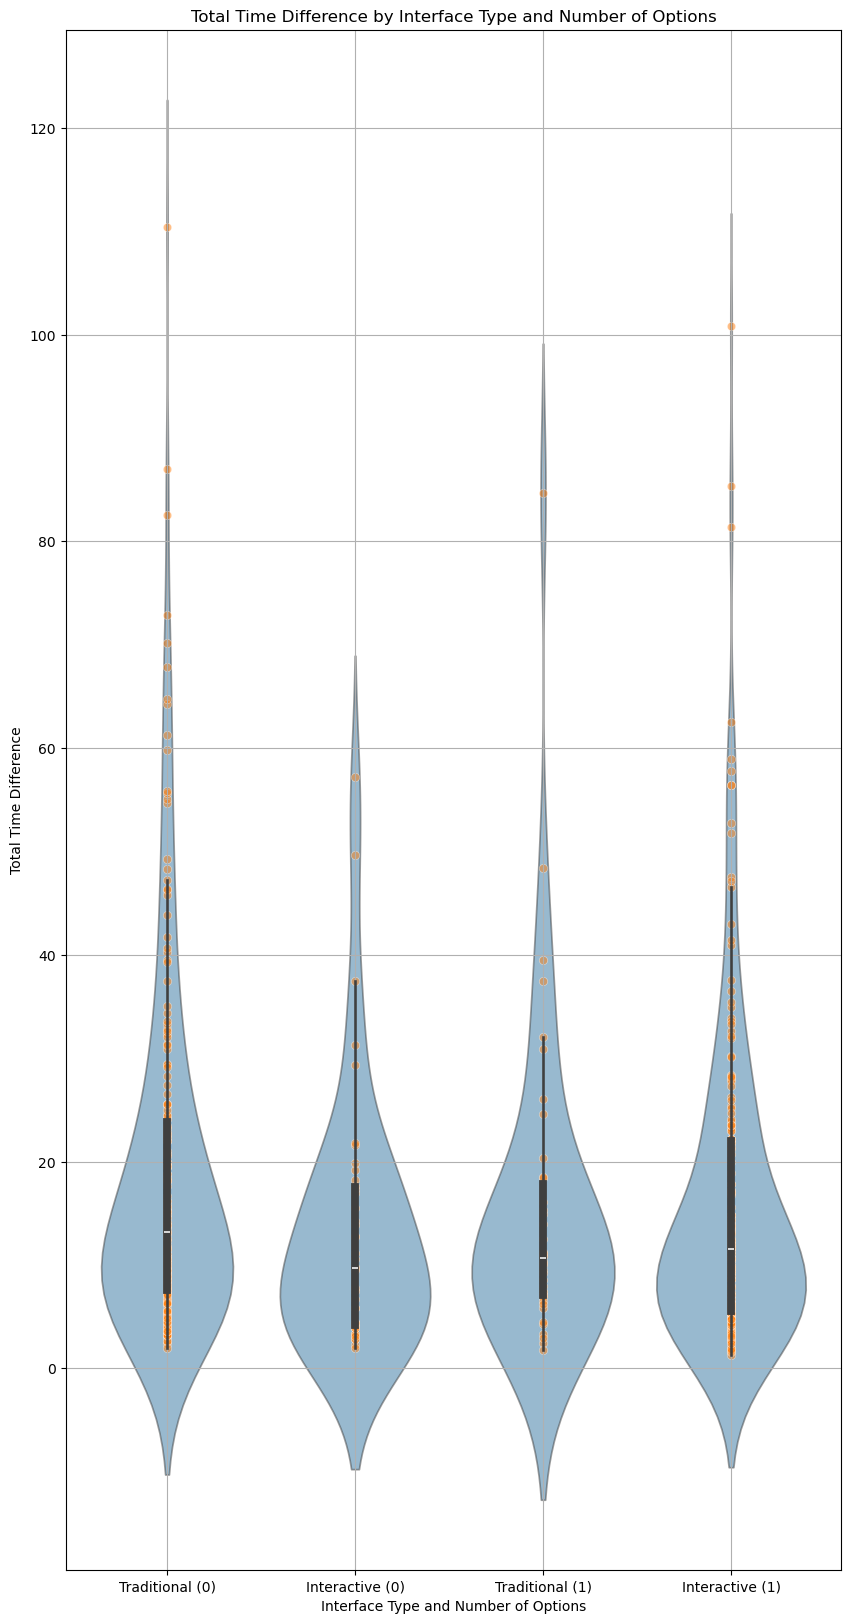

In [19]:
import seaborn as sns

voting_time_modeling_df['Interface_NumOptions'] = voting_time_modeling_df['Interface_Type'].astype(str) + '_' + voting_time_modeling_df['Num_Options'].astype(str)

plt.figure(figsize=(10, 20))

# overlay a voilin plot
sns.violinplot(data=voting_time_modeling_df, x='Interface_NumOptions', y='total_time_diff', alpha=0.5)

sns.scatterplot(data=voting_time_modeling_df, x='Interface_NumOptions', y='total_time_diff', alpha=0.5)



plt.xticks(ticks=[0, 1, 2, 3], labels=['Traditional (0)', 'Interactive (0)', 'Traditional (1)', 'Interactive (1)'])
plt.xlabel('Interface Type and Number of Options')
plt.ylabel('Total Time Difference')
plt.title('Total Time Difference by Interface Type and Number of Options')
plt.grid(True)
plt.show()


### RE: Section 6.1 - Statistical Significance in Total time

In [20]:
# 1. Aggregate total time per option across both organization and voting for each (user_id, option_id, version)
aggregated_total_time_data = combined_data.groupby(['user_id', 'option_id', 'version']).agg({
    'time_diff': 'sum'  # Sum the time differences to get total time per option
}).reset_index()

# Rename 'time_diff' to 'total_time' for clarity
aggregated_total_time_data.rename(columns={'time_diff': 'total_time'}, inplace=True)

# 2. Re-assign Interface_Type and Num_Options after aggregation
aggregated_total_time_data['Interface_Type'] = aggregated_total_time_data['version'].apply(extract_interface_type)
aggregated_total_time_data['Num_Options'] = aggregated_total_time_data['version'].apply(extract_num_options)

# 3. Separate data for each condition (total time per option)
t_short_interactive_total = aggregated_total_time_data[
    (aggregated_total_time_data['Interface_Type'] == 1) & (aggregated_total_time_data['Num_Options'] == 0)
]['total_time'].values

t_short_static_total = aggregated_total_time_data[
    (aggregated_total_time_data['Interface_Type'] == 0) & (aggregated_total_time_data['Num_Options'] == 0)
]['total_time'].values

t_long_interactive_total = aggregated_total_time_data[
    (aggregated_total_time_data['Interface_Type'] == 1) & (aggregated_total_time_data['Num_Options'] == 1)
]['total_time'].values

t_long_static_total = aggregated_total_time_data[
    (aggregated_total_time_data['Interface_Type'] == 0) & (aggregated_total_time_data['Num_Options'] == 1)
]['total_time'].values

def gamma_total_time_model():
    # Short Interactive - Gamma Distribution
    alpha_short_interactive = numpyro.sample('alpha_short_interactive', dist.Gamma(2.0, 0.5))
    beta_short_interactive = numpyro.sample('beta_short_interactive', dist.Gamma(1.0, 1.0))
    numpyro.sample('obs_short_interactive', dist.Gamma(alpha_short_interactive, beta_short_interactive), obs=t_short_interactive_total)
    
    # Short Static - Gamma Distribution
    alpha_short_static = numpyro.sample('alpha_short_static', dist.Gamma(2.0, 0.5))
    beta_short_static = numpyro.sample('beta_short_static', dist.Gamma(1.0, 1.0))
    numpyro.sample('obs_short_static', dist.Gamma(alpha_short_static, beta_short_static), obs=t_short_static_total)
    
    # Long Interactive - Gamma Distribution
    alpha_long_interactive = numpyro.sample('alpha_long_interactive', dist.Gamma(2.0, 0.5))
    beta_long_interactive = numpyro.sample('beta_long_interactive', dist.Gamma(1.0, 1.0))
    numpyro.sample('obs_long_interactive', dist.Gamma(alpha_long_interactive, beta_long_interactive), obs=t_long_interactive_total)
    
    # Long Static - Gamma Distribution
    alpha_long_static = numpyro.sample('alpha_long_static', dist.Gamma(2.0, 0.5))
    beta_long_static = numpyro.sample('beta_long_static', dist.Gamma(1.0, 1.0))
    numpyro.sample('obs_long_static', dist.Gamma(alpha_long_static, beta_long_static), obs=t_long_static_total)

# Initialize NUTS sampler and run MCMC
nuts_kernel = NUTS(gamma_total_time_model)
mcmc_total_time = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=2, progress_bar=True)
rng_key = random.PRNGKey(0)
mcmc_total_time.run(rng_key)

# Retrieve posterior samples and convert to InferenceData for ArviZ
posterior_samples_total_time = mcmc_total_time.get_samples()
idata_total_time = az.from_numpyro(mcmc_total_time)

# Display summary for each condition
summary_total_time = az.summary(idata_total_time, round_to=2)
print("\nGamma Model Summary for Total Time per Option:")
print(summary_total_time)


/tmp/ipykernel_123572/1277429266.py:53: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_total_time = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=2, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 3501.68it/s, 15 steps of size 2.82e-01. acc. prob=0.91]



Gamma Model Summary for Total Time per Option:
                         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_long_interactive   2.31  0.20    1.95     2.70       0.01     0.00   
alpha_long_static        1.57  0.14    1.32     1.85       0.00     0.00   
alpha_short_interactive  2.90  0.58    1.83     4.00       0.02     0.01   
alpha_short_static       1.74  0.33    1.14     2.36       0.01     0.01   
beta_long_interactive    0.09  0.01    0.07     0.11       0.00     0.00   
beta_long_static         0.08  0.01    0.07     0.10       0.00     0.00   
beta_short_interactive   0.14  0.03    0.09     0.19       0.00     0.00   
beta_short_static        0.11  0.03    0.07     0.16       0.00     0.00   

                         ess_bulk  ess_tail  r_hat  
alpha_long_interactive    1448.36   1306.33    1.0  
alpha_long_static         1408.93   1399.00    1.0  
alpha_short_interactive   1098.23    945.49    1.0  
alpha_short_static        1276.98   1171.44    1.0  
be

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style='whitegrid')

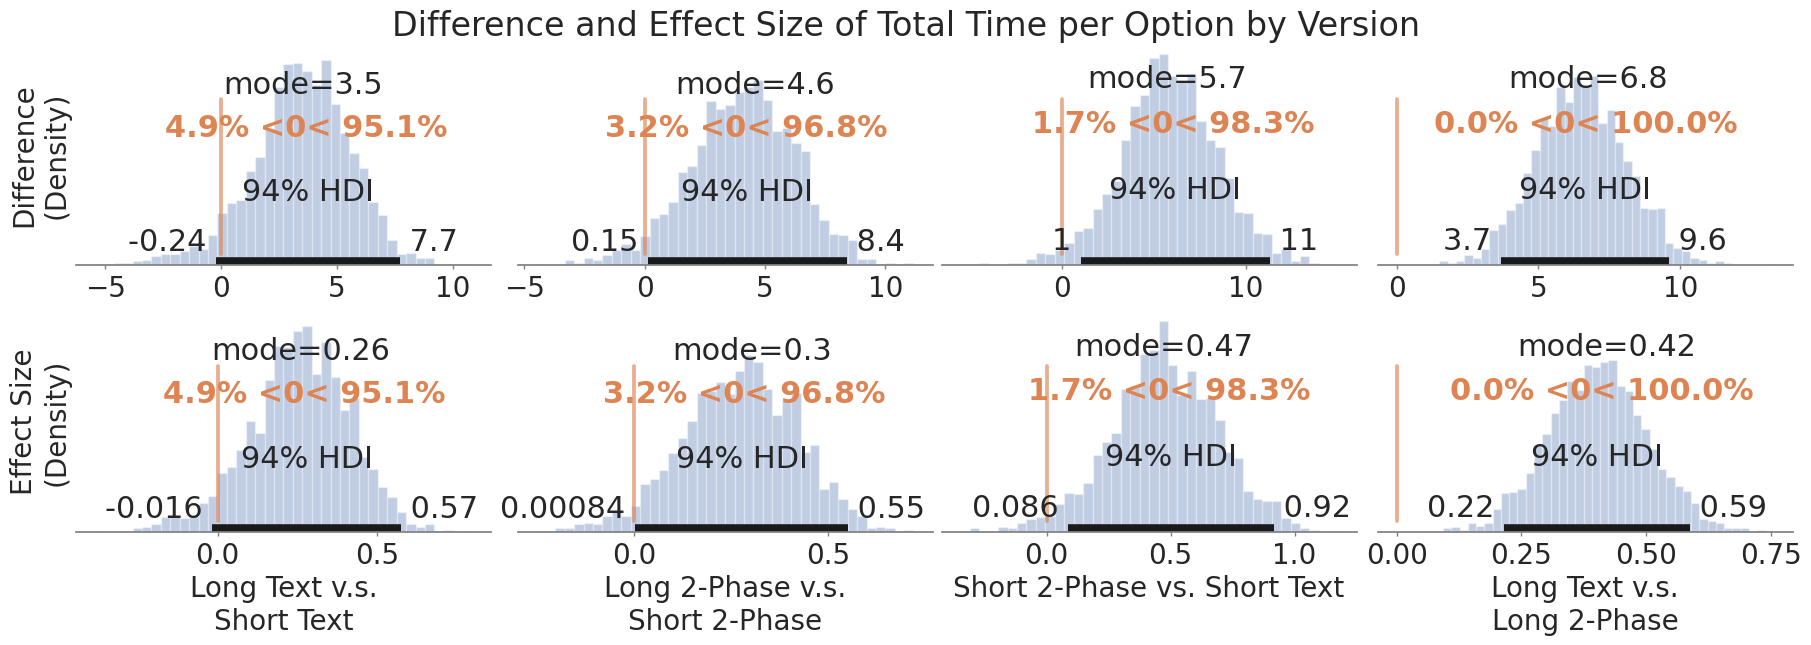

In [24]:
# After we complete running the MCMC and have `idata_total_time` available

from numpyro.infer import Predictive

# Using Predictive to generate posterior predictive samples
predictive = Predictive(gamma_total_time_model, posterior_samples_total_time)
posterior_predictive = predictive(random.PRNGKey(1))

# Mapping versions:
# v0: short static (Short Text)
# v1: short interactive (Short 2-Phase)
# v2: long static (Long Text)
# v3: long interactive (Long 2-Phase)

# Extract posterior samples for parameters again (just for clarity in this code block)
alpha_long_interactive = posterior_samples_total_time['alpha_long_interactive']
beta_long_interactive = posterior_samples_total_time['beta_long_interactive']
alpha_long_static = posterior_samples_total_time['alpha_long_static']
beta_long_static = posterior_samples_total_time['beta_long_static']
alpha_short_interactive = posterior_samples_total_time['alpha_short_interactive']
beta_short_interactive = posterior_samples_total_time['beta_short_interactive']
alpha_short_static = posterior_samples_total_time['alpha_short_static']
beta_short_static = posterior_samples_total_time['beta_short_static']

def gamma_mean(alpha, beta):
    return alpha / beta

def gamma_sd(alpha, beta):
    return np.sqrt(alpha) / beta

# Compute means for each version
mean_v0 = gamma_mean(alpha_short_static, beta_short_static)       # short static
mean_v1 = gamma_mean(alpha_short_interactive, beta_short_interactive) # short interactive
mean_v2 = gamma_mean(alpha_long_static, beta_long_static)         # long static
mean_v3 = gamma_mean(alpha_long_interactive, beta_long_interactive) # long interactive

# Compute SDs for each version
sd_v0 = gamma_sd(alpha_short_static, beta_short_static)
sd_v1 = gamma_sd(alpha_short_interactive, beta_short_interactive)
sd_v2 = gamma_sd(alpha_long_static, beta_long_static)
sd_v3 = gamma_sd(alpha_long_interactive, beta_long_interactive)

# Define contrasts using the specified version order:
# According to user instructions, "vX vs vY" means vX - vY.
# and the given order_label:
order_label = {
    "v1 vs v0": "Short 2-Phase vs. Short Text",
    "v3 vs v2": "Long Text v.s.\nLong 2-Phase",
    "v2 vs v0": "Long Text v.s.\nShort Text",
    "v3 vs v1": "Long 2-Phase v.s.\nShort 2-Phase"
}

# Calculate contrasts (differences) according to vX vs vY = mean_vX - mean_vY
contrasts = {
    "v1 vs v0": mean_v1 - mean_v0,
    "v3 vs v2": mean_v3 - mean_v2,
    "v2 vs v0": mean_v2 - mean_v0,
    "v3 vs v1": mean_v3 - mean_v1,
}

# Compute pooled SDs for each contrast
pooled_sds = {
    "v1 vs v0": np.sqrt((sd_v1**2 + sd_v0**2) / 2),
    "v3 vs v2": np.sqrt((sd_v3**2 + sd_v2**2) / 2),
    "v2 vs v0": np.sqrt((sd_v2**2 + sd_v0**2) / 2),
    "v3 vs v1": np.sqrt((sd_v3**2 + sd_v1**2) / 2),
}

desired_order = ["v2 vs v0", "v3 vs v1", "v1 vs v0", "v3 vs v2"]

# Effect sizes
effect_sizes = {k: contrasts[k] / pooled_sds[k] for k in contrasts.keys()}

# Convert to arrays
contrasts = {k: np.array(v) for k, v in contrasts.items()}
effect_sizes = {k: np.array(v) for k, v in effect_sizes.items()}

# Create InferenceData objects for differences and effect sizes
idata_diff = az.from_dict(posterior={label: contrasts[label] for label in desired_order})
idata_effect_sizes = az.from_dict(posterior={label: effect_sizes[label] for label in desired_order})

# Prepare figure layout for the two rows
n_cols = len(desired_order)
fig, axes = plt.subplots(
    2, n_cols, figsize=(18, 6), sharey='row', constrained_layout=True
)

# Define histogram bin size
bin_size = 40

# Plot differences (first row)
for i, label in enumerate(desired_order):
    az.plot_posterior(
        idata_diff,
        var_names=[label],
        ax=axes[0, i],
        hdi_prob=0.94,
        point_estimate="mode",
        ref_val=0,
        kind="hist",
        bins=bin_size,
        textsize=20,
    )
    axes[0, i].set_title("", fontsize=18)
    axes[0, i].grid(axis="x", linestyle="", alpha=0.6)
    axes[0, i].grid(axis="y", linestyle="", alpha=0.0)

# Plot effect sizes (second row)
for i, label in enumerate(desired_order):
    az.plot_posterior(
        idata_effect_sizes,
        var_names=[label],
        ax=axes[1, i],
        hdi_prob=0.94,
        point_estimate="mode",
        ref_val=0,
        kind="hist",
        bins=bin_size,
        textsize=20,
    )
    axes[1, i].set_title("")
    axes[1, i].grid(axis="x", linestyle="", alpha=0.6)
    axes[1, i].grid(axis="y", linestyle="", alpha=0.0)

# Adjust labels and layout
axes[0, 0].set_ylabel("Difference\n(Density)", fontsize=20)
axes[1, 0].set_ylabel("Effect Size\n(Density)", fontsize=20)

# Set the x-axis label for the last row of plots with the custom names
for i, label in enumerate(desired_order):
    axes[1, i].set_xlabel(order_label[label], fontsize=20)

plt.suptitle("Difference and Effect Size of Total Time per Option by Version", fontsize=24, y=1.05)
plt.savefig(f'{path}/time_diff_per_option_effect_size_by_version.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'{path}/time_diff_per_option_effect_size_by_version.png', format='png', bbox_inches='tight')
plt.show()


### Plotting the image

In [35]:
import warnings

# Define the order of the versions and the colors
version_order = ['v1_short_traditional', 'v2_short_interactive', 'v3_long_traditional', 'v4_long_interactive']

version_labels = {
    'v1_short_traditional': 'Short\nText',
    'v2_short_interactive': 'Short\n2-Phase',
    'v3_long_traditional': 'Long\nText',
    'v4_long_interactive': 'Long\n2-Phase'
}

palette = 'coolwarm'
colors = sns.color_palette(palette, 4)
color_map = {'v1': colors[1], 'v2': colors[0], 'v3': colors[2], 'v4': colors[3]}

# colors = ['#98DDCA', '#FFD3B4', '#D5ECC2', '#FFAAA7']
colors = [colors[1], colors[0], colors[2], colors[3]]
palette = dict(zip(version_order, colors))

# set background to white
sns.set_style("whitegrid")

# Set font sizes
plt.rcParams.update({
    'font.size': 16,            # Global font size
    'axes.titlesize': 18,       # Font size of the title
    'axes.labelsize': 16,       # Font size of the x and y labels
    'xtick.labelsize': 16,      # Font size of the x tick labels
    'ytick.labelsize': 16,      # Font size of the y tick labels
    'legend.fontsize': 16,      # Font size of the legend
    'figure.titlesize': 20      # Font size of the figure title
})

# Define a function to create violin plots and scatter plots overlaid with text moved to the right of the line
def plot_violin_scatter_overlay(data, x_col, y_col, title, xlabel, ylabel, zoom_iqr=False, set_range=None):
    fig, ax = plt.subplots(figsize=(10, 8))  # Increase the canvas height
    
    warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')
    sns.violinplot(x=x_col, y=y_col, data=data, hue=x_col, order=version_order, cut=0, inner='quartile', ax=ax, palette=palette, dodge=False, legend=False)

    # sns.stripplot(x=x_col, y=y_col, data=data, jitter=True, alpha=0.3, size=5, hue='user_id' , order=version_order, ax=ax) #color='black'

    # Define the markers you want to use
    markers = ['o']
    # , 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h'

    # Plot each version with a unique color and differentiate users by marker
    for version in version_order:
        version_data = data[data[x_col] == version]
        for i, user in enumerate(version_data['user_id'].unique()):
            user_data = version_data[version_data['user_id'] == user]
            marker = markers[i % len(markers)]
            sns.stripplot(x=x_col, y=y_col, data=user_data, jitter=True, alpha=0.3, size=5, marker=marker, color='black', order=version_order, ax=ax, legend=False)
    
    if zoom_iqr:
        # Calculate IQR
        Q1 = data[y_col].quantile(0.25)
        Q3 = data[y_col].quantile(0.75)
        IQR = Q3 - Q1
        # print(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        ax.set_ylim(0, Q3 + 2 * IQR)
    
    # limit y-axis
    if set_range:
        ax.set_ylim(0, set_range)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(ticks=range(len(version_order)), labels=[version_labels[version] for version in version_order])  # Adjust the rotation for better readability
    # plt.xticks(rotation=45)  # Adjust the rotation for better readability
    plt.grid(axis='y')  # Add horizontal grid lines

    for idx, version in enumerate(version_order):
        version_data = data[data[x_col] == version]
        Q1 = version_data[y_col].quantile(0.25)
        median = version_data[y_col].quantile(0.5)
        Q3 = version_data[y_col].quantile(0.75)
        ax.text(idx + 0.2, Q1, f'{Q1:.1f}', horizontalalignment='left', size='small', color='black', alpha=0.7, bbox=dict(facecolor='white', edgecolor='none', alpha=0.75))
        ax.text(idx + 0.2, median, f'{median:.1f}', horizontalalignment='left', size='small', color='black', alpha=0.7, bbox=dict(facecolor='white', edgecolor='none', alpha=0.75))
        ax.text(idx + 0.2, Q3, f'{Q3:.1f}', horizontalalignment='left', size='small', color='black', alpha=0.7, bbox=dict(facecolor='white', edgecolor='none', alpha=0.75))

    # save the plot
    plt.savefig(f'{path}' + '/'+ title + '.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(f'{path}' + '/' + title + '.png', format='png', bbox_inches='tight')
    plt.show()


In [36]:
plot_violin_scatter_overlay(combined_data, 'version', 'time_diff', 'Time to Micro Decisions Across Different Interfaces', 'Version', 'Time to Micro Decisions (seconds)', zoom_iqr=True)